In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys  
sys.path.insert(0, r'C:\Users\Rodrigo\Desktop\PhD\Study1\Physiological_Data')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

In [4]:
import warnings
from Signals_Processing import *
from Process import *
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import ensemble, feature_selection
import pickle

In [5]:
os.chdir('C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\')
os.getcwd()

'C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system'

In [66]:
"""Load Data from Folder"""

folder = os.getcwd() + "\\Training Models\\"
participant = "P2_stimuli"
path = folder + participant
path

'C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Models\\P2_stimuli'

In [67]:
EEG_baseline = pd.read_csv(r'C:\Users\Rodrigo\Desktop\PhD\loop-system\Training Models\P2\EEGbaseline.csv', sep=";", index_col=0)

In [68]:
df_baseline = pd.read_csv(r'C:\Users\Rodrigo\Desktop\PhD\loop-system\Training Models\P2\baseline.csv', sep=";", index_col=0)

In [69]:
EEG_baseline

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,EEG_30_gamma,EEG_30_theta,EEG_31_alpha,EEG_31_betha,EEG_31_gamma,EEG_31_theta,EEG_32_alpha,EEG_32_betha,EEG_32_gamma,EEG_32_theta
0,0.000005,-0.000055,-0.000074,-0.000052,2.362246e-07,-0.000007,-0.000012,-0.000006,-5.421571e-07,-0.000001,...,-0.000026,-0.000019,-1.100299e-07,-2.769457e-07,-2.984914e-07,-3.109460e-07,-8.758924e-07,-1.150916e-08,4.653503e-08,0.000004


In [70]:
df_baseline[:27]

,Avg HR,Min HR,Max HR,SD,AVG RR,Minimum RR,Maximum RR,SDNN,RMSSD,NN50,...,SD1,SD2,SD2/SD1,HRV VLF Power,HRV LF Power,HRV HF Power,HRV Total Power,HRV LF (nu),HRV HF (nu),HRV LF/HF
0,70.49255,59.40264,84.502347,4.850715,0.855096,0.710039,1.010056,57.5227,43.7924,58,...,31.0,75.2,2.4258,1350.05,787.6,832.25,3060.5,46.05,48.66,0.95


In [71]:
os.chdir(path)
(
    users,
    EEG_epochs,
    EEG_filtered,
    Signals_epochs,
    Signals,
    EEG_dict,
    features_signals,
    features_EEG,
    features_epochs,
    features_epochs_EEG,
) = ({}, {}, {}, {}, {}, {}, {}, {}, {}, {})

for root, dirs, files in os.walk(path):
    for fname in files:
        if fname.endswith(".xdf"):
            users[fname] = Run_files(fname)

In [72]:
users

{'P2_stimuli.xdf': [{'info': defaultdict(list,
               {'name': ['PsychoPy Markers'],
                'type': ['Markers'],
                'channel_count': ['2'],
                'channel_format': ['string'],
                'source_id': ['Example'],
                'nominal_srate': ['0.000000000000000'],
                'version': ['1.100000000000000'],
                'created_at': ['349871.3516932000'],
                'uid': ['bd1c6896-8e07-4740-9254-afd1193dc2ed'],
                'session_id': ['default'],
                'hostname': ['DESKTOP-8HVM7BE'],
                'v4address': [None],
                'v4data_port': ['16572'],
                'v4service_port': ['16572'],
                'v6address': [None],
                'v6data_port': ['16572'],
                'v6service_port': ['16572'],
                'desc': [None],
                'stream_id': 3,
                'effective_srate': 0}),
   'footer': {'info': defaultdict(list,
                {'first_timestamp'

In [18]:
Opensignals_fs = 100
EEG_fs = 250
resolution = 16

In [27]:
sensors = ["ECG", "EDA", "RESP"]
data = {}
for user in users.keys():
    data[user.split(".")[0]] = Load_Data(
        users[user],
        "OpenSignals",
        "openvibeSignal",
        "PsychoPy Markers",
        "PsychoPy Markers",
        sensors,
    )

    data[user.split(".")[0]]["Markers"].pop(0)
    data[user.split(".")[0]]["Markers"].pop(-1)
    data[user.split(".")[0]]["Markers Timestamps"].pop(0)
    data[user.split(".")[0]]["Markers Timestamps"].pop(-1)

onset, offset, videos, valence, arousal = ({}, {}, {}, {}, {})
for user in data.keys():
    valence[user] = data[user]["Valence"]
    arousal[user] = data[user]["Arousal"]
    onset[user], offset[user], videos[user] = getMarkers(
        data[user]["Markers"], data[user]["Markers Timestamps"]
    )

onset_index = {}
offset_index = {}
onset_index_EEG = {}
offset_index_EEG = {}

for user in data.keys():
    onset_index[user], offset_index[user] = getMarkersIndex(
        onset[user], offset[user], data[user]["Signals"]["Time"]
    )
    onset_index_EEG[user], offset_index_EEG[user] = getMarkersIndex(
        onset[user], offset[user], np.array(data[user]["EEG"]["Time"])
    )

events_diff = {}

for keys in onset.keys():
    events_diff[keys] = CalculateEventsDiff(onset[keys], offset[keys])

In [28]:
videos

{'P2_stimuli': ['EMDB/Horror/1006.avi',
  'EMDB/Horror/1003.avi',
  'EMDB/Horror/1008.avi',
  'EMDB/Horror/1001.avi',
  'EMDB/Horror/1005.avi',
  'EMDB/Scenery/5001.avi',
  'EMDB/Scenery/5003.avi',
  'EMDB/Scenery/5006.avi',
  'EMDB/Scenery/5008.avi',
  'EMDB/Scenery/5005.avi']}

In [29]:
onset,offset

({'P2_stimuli': [438745.7269385388,
   438808.2951466561,
   438864.25674964837,
   438925.6665365212,
   438987.8435747792,
   439047.53296873794,
   439110.56094992114,
   439174.48702134663,
   439234.539018812,
   439293.77118342725]},
 {'P2_stimuli': [438785.7764478136,
   438848.66766778746,
   438904.34716178494,
   438966.31814972067,
   439028.53320671496,
   439087.7035293833,
   439151.25192086876,
   439215.0583530362,
   439275.1509010602,
   439334.3822368681]})

In [30]:
data

{'P2_stimuli': {'Signals':                 Time      ECG     EDA     RESP
  0      438674.576322  0.15705  3.2650  0.55627
  1      438674.586325  0.16945  3.2913  0.53595
  2      438674.596328  0.18293  3.2574  0.51324
  3      438674.606331  0.20215  3.2543  0.49356
  4      438674.616334  0.21527  3.2528  0.47104
  ...              ...      ...     ...      ...
  68603  439360.818894 -0.04241  4.5341  0.07672
  68604  439360.828897 -0.04115  4.5135  0.07933
  68605  439360.838900 -0.04816  4.5013  0.07635
  68606  439360.848903 -0.33234  4.5090  0.07828
  68607  439360.858906 -0.17879  4.4956  0.07764
  
  [68608 rows x 4 columns],
  'EEG':                  Time        EEG_1        EEG_2         EEG_3         EEG_4  \
  0       438674.392539 -7822.294922  2921.404785  54176.437500 -18305.408203   
  1       438674.396539 -7824.718750  2919.520264  54219.207031 -18312.937500   
  2       438674.400539 -7828.220703  2916.558594  54498.683594 -18316.705078   
  3       438674.404539 -

## EDA Full Experiment

<IPython.core.display.Javascript object>


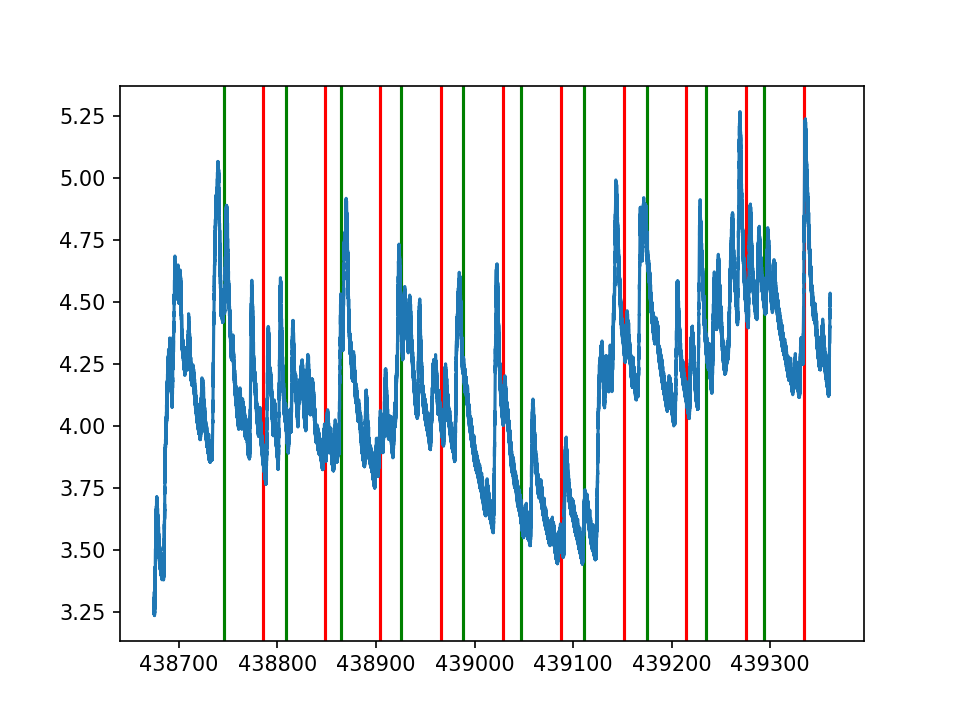

In [31]:
plt.figure()
for user in data.keys():
    for timestamp,markers in zip(data[user]["Markers Timestamps"],data[user]["Markers"]):
        if (markers[1] == '1'):
            plt.axvline(x=timestamp,color='r')
        elif(markers[1] == '0'):
            plt.axvline(x=timestamp,color='g')
    plt.plot(data[user]["Signals"]["Time"],data[user]["Signals"]["EDA"])

## ECG Full Experiment

<IPython.core.display.Javascript object>


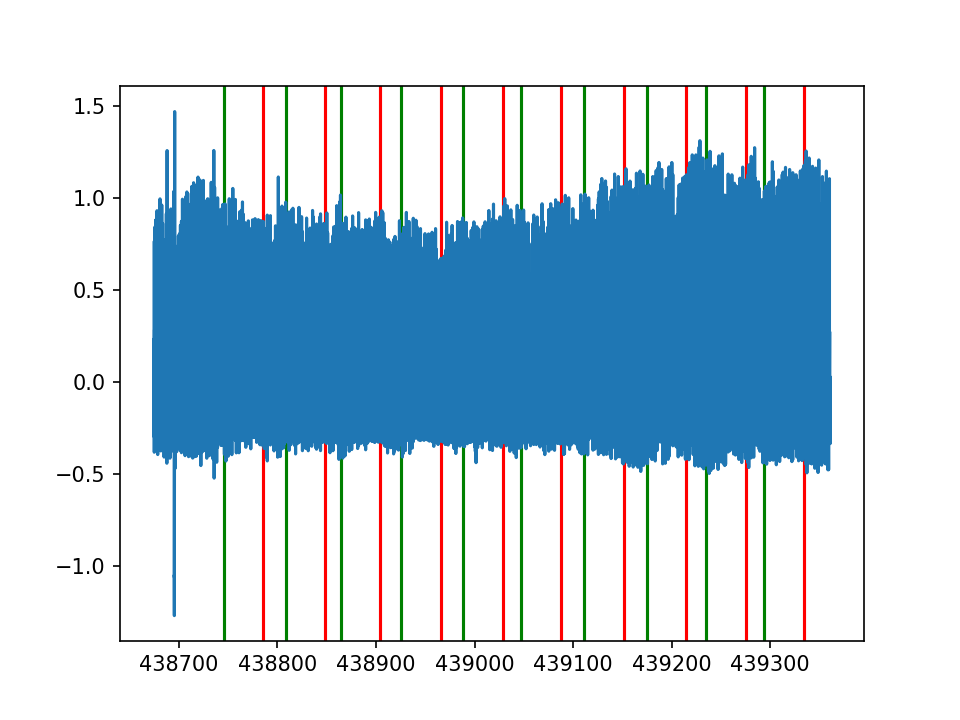

In [32]:
plt.figure()
for user in data.keys():
    for timestamp,markers in zip(data[user]["Markers Timestamps"],data[user]["Markers"]):
        if (markers[1] == '1'):
            plt.axvline(x=timestamp,color='r')
        elif(markers[1] == '0'):
            plt.axvline(x=timestamp,color='g')
    plt.plot(data[user]["Signals"]["Time"],data[user]["Signals"]["ECG"])

## RESP Full Experiment

<IPython.core.display.Javascript object>


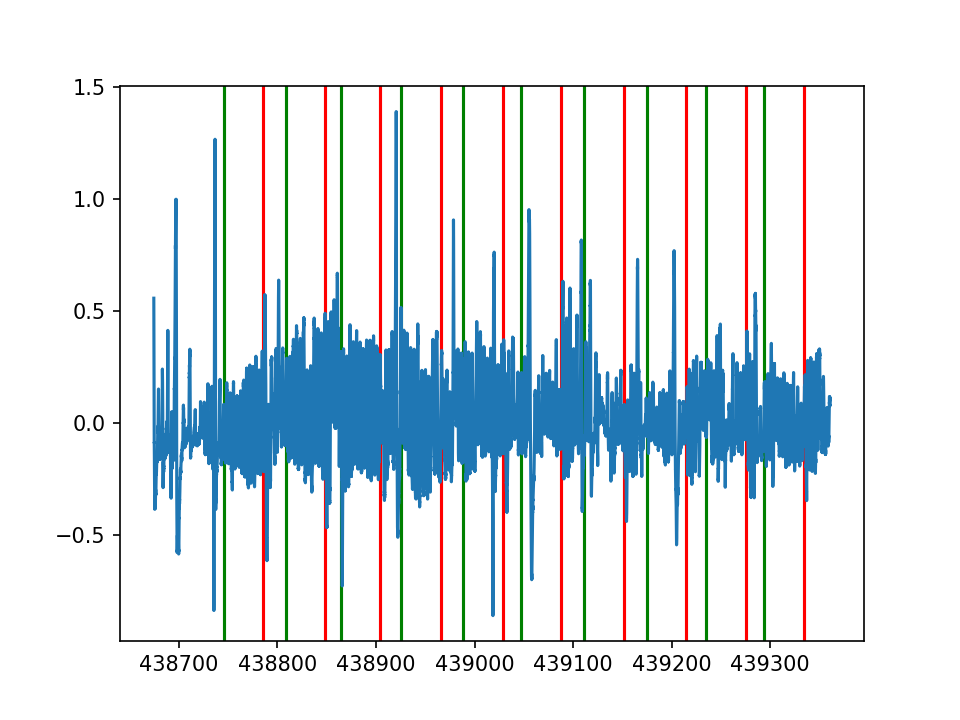

In [33]:
plt.figure()
for user in data.keys():
    for timestamp,markers in zip(data[user]["Markers Timestamps"],data[user]["Markers"]):
        if (markers[1] == '1'):
            plt.axvline(x=timestamp,color='r')
        elif(markers[1] == '0'):
            plt.axvline(x=timestamp,color='g')
    plt.plot(data[user]["Signals"]["Time"],data[user]["Signals"]["RESP"])

## EEG Full Experiment

<IPython.core.display.Javascript object>


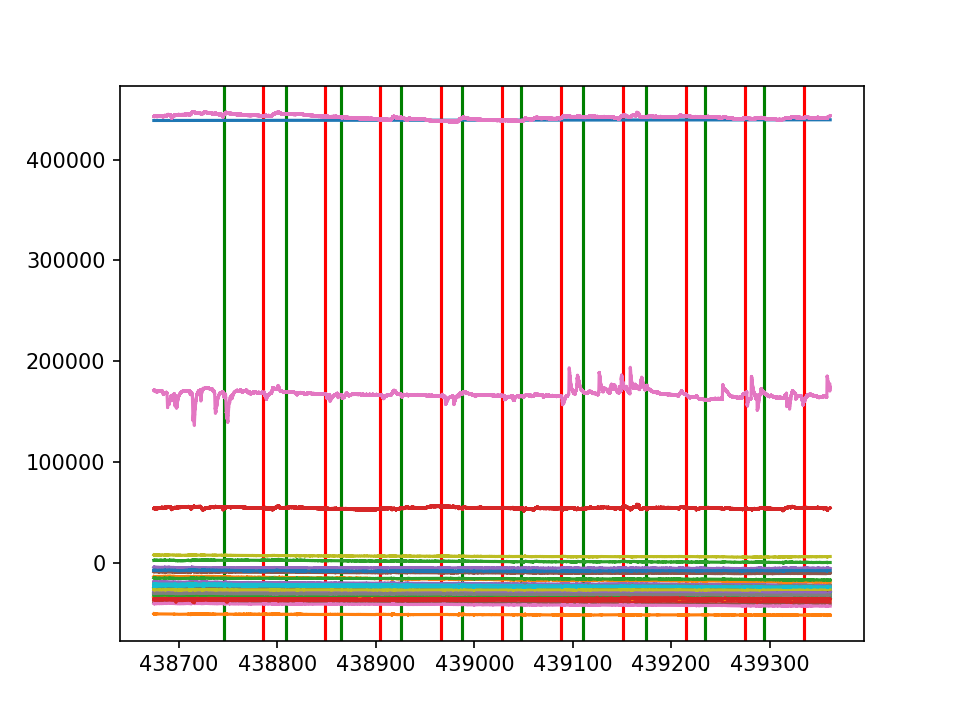

In [34]:
plt.figure()
for user in data.keys():
    for timestamp,markers in zip(data[user]["Markers Timestamps"],data[user]["Markers"]):
        if (markers[1] == '1'):
            plt.axvline(x=timestamp,color='r')
        elif(markers[1] == '0'):
            plt.axvline(x=timestamp,color='g')
    plt.plot(data[user]["EEG"]["Time"],data[user]["EEG"])

## Process Ideal Window (40sec)

In [35]:
"""EEG Processing"""
EEG_filtered = filterEEG(data, EEG_fs)
EEG_filtered = getEEGChannels(EEG_filtered)
EEG_epochs = getEpochs(EEG_filtered, onset_index_EEG, events_diff, EEG_fs)
EEG_dict = getVideosDict(EEG_epochs, videos)
features_EEG = getEEGBands(EEG_dict, EEG_fs)

In [36]:
features_EEG

{'P2_stimuli': {'EMDB/Horror/1006.avi': {'EEG_1': {'alpha': 8.013410147435283e-05,
    'betha': 5.126600912817288e-05,
    'gamma': 5.2824040191595814e-05,
    'theta': 0.00026038641146093486},
   'EEG_2': {'alpha': 1.7945180100463177e-05,
    'betha': 1.443170725094536e-05,
    'gamma': 1.3710088690582438e-05,
    'theta': 5.727014655399791e-05},
   'EEG_3': {'alpha': 0.00018360144391194424,
    'betha': 0.0002680317695960599,
    'gamma': 0.0013061796727779108,
    'theta': 0.0002761939155271362},
   'EEG_4': {'alpha': 1.388431733345239e-05,
    'betha': 1.0827709938230756e-05,
    'gamma': 8.173842573786647e-06,
    'theta': 3.728115873248223e-05},
   'EEG_5': {'alpha': 2.195431728342131e-05,
    'betha': 1.2700529066024637e-05,
    'gamma': 9.433741512696008e-06,
    'theta': 4.416262133745697e-05},
   'EEG_6': {'alpha': 2.4301862197784542e-05,
    'betha': 3.7092706701884176e-05,
    'gamma': 0.00014432382517956362,
    'theta': 3.008167355473524e-05},
   'EEG_7': {'alpha': 3.9861

In [37]:
EEG_list = EEG_baseline.loc[0].values.flatten().tolist()

In [38]:
warnings.filterwarnings("ignore")
Signals_epochs = getSignalsEpochs(data, onset_index, events_diff, Opensignals_fs)
Signals = getVideosDict(Signals_epochs, videos)
features_signals = getFeatures(Signals, Opensignals_fs, resolution)

In [39]:
columns = list()
category, video = [], []

for key in features_epochs_EEG.keys():
    user = key
    print(user)
videos = list(features_EEG[user].keys())
for epochs in features_EEG[user][videos[0]].keys():
    for bands in features_EEG[user][videos[0]][epochs].keys():
        columns.append(epochs + "_" + bands)
df_EEG = pd.DataFrame(columns=columns)

for users in features_EEG.keys():
    temp_df = pd.DataFrame(columns=columns)

    for i, videos in enumerate(features_EEG[users].keys()):
        if videos != "baseline":
            temp_list = list()
            for channel in features_EEG[users][videos].keys():
                for band in features_EEG[users][videos][channel].keys():
                    temp_list.append(
                        features_EEG[users][videos][channel][band]
                    )
            temp_df.loc[i] = list(np.array(temp_list)-np.array(EEG_list))
            category.append(videos.split("/")[1])
            video.append(videos.split("/")[2])

    df_EEG = pd.concat([df_EEG, temp_df], ignore_index=True)
df_EEG["Category"] = category
df_EEG["Video"] = video

In [40]:
df_EEG

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,EEG_31_alpha,EEG_31_betha,EEG_31_gamma,EEG_31_theta,EEG_32_alpha,EEG_32_betha,EEG_32_gamma,EEG_32_theta,Category,Video
0,0.000075,0.000106,0.000127,0.000312,0.000018,0.000022,0.000025,0.000063,0.000184,0.000269,...,0.000004,0.000003,0.000002,0.000011,0.000045,0.000027,0.000018,0.000155,Horror,1006.avi
1,0.000086,0.000123,0.000134,0.000351,0.000020,0.000023,0.000025,0.000064,0.000185,0.000281,...,0.000004,0.000003,0.000002,0.000012,0.000045,0.000026,0.000015,0.000154,Horror,1003.avi
2,0.000145,0.000107,0.000095,0.000560,0.000027,0.000020,0.000017,0.000092,0.000183,0.000271,...,0.000005,0.000003,0.000002,0.000016,0.000054,0.000028,0.000015,0.000154,Horror,1008.avi
3,0.000079,0.000121,0.000148,0.000376,0.000017,0.000022,0.000025,0.000060,0.000168,0.000265,...,0.000004,0.000003,0.000002,0.000012,0.000041,0.000023,0.000014,0.000124,Horror,1001.avi
4,0.000118,0.000100,0.000098,0.000479,0.000024,0.000019,0.000020,0.000085,0.000176,0.000260,...,0.000004,0.000003,0.000002,0.000014,0.000052,0.000029,0.000024,0.000162,Horror,1005.avi
5,0.000119,0.000126,0.000139,0.000775,0.000024,0.000023,0.000027,0.000111,0.000219,0.000289,...,0.000004,0.000003,0.000003,0.000016,0.000044,0.000029,0.000024,0.000139,Scenery,5001.avi
6,0.000103,0.000164,0.000166,0.000663,0.000020,0.000029,0.000031,0.000100,0.000184,0.000305,...,0.000004,0.000003,0.000002,0.000014,0.000046,0.000027,0.000022,0.000157,Scenery,5003.avi
7,0.000096,0.000106,0.000121,0.000641,0.000022,0.000019,0.000021,0.000109,0.000194,0.000244,...,0.000004,0.000002,0.000002,0.000017,0.000050,0.000022,0.000015,0.000200,Scenery,5006.avi
8,0.000076,0.000087,0.000103,0.000549,0.000017,0.000017,0.000020,0.000076,0.000181,0.000282,...,0.000003,0.000002,0.000002,0.000012,0.000042,0.000020,0.000016,0.000168,Scenery,5008.avi
9,0.000121,0.000240,0.000325,0.000777,0.000023,0.000044,0.000058,0.000138,0.000182,0.000274,...,0.000004,0.000003,0.000003,0.000019,0.000053,0.000031,0.000023,0.000224,Scenery,5005.avi


In [41]:
category, videos = [], []

for key in features_signals.keys():
    user = key
video = list(features_signals[user].keys())
df = pd.DataFrame(columns=features_signals[user][video[0]].columns)
for users in features_signals.keys():
    for epoch in features_signals[users].keys():
        if epoch != "baseline":
            df = pd.concat([df, features_signals[users][epoch].sub(df_baseline)], ignore_index=True)
            category.append(epoch.split("/")[1])
            videos.append(epoch.split("/")[2])
df["Category"] = category
df["Video"] = videos

In [42]:
df

,Avg HR,Min HR,Max HR,SD,AVG RR,Minimum RR,Maximum RR,SDNN,RMSSD,NN50,...,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category,Video
0,-0.597464,3.739481,-6.599731,-1.656104,0.005119,0.060153,-0.059819,-18.3745,-11.5425,-51,...,-9.6369,-0.017064,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.332245,Horror,1006.avi
1,0.019134,-0.011415,-4.522164,-0.231859,-0.000440,0.040146,0.000194,-0.2933,4.1304,-40,...,-13.3434,-0.030989,-20.0,-12.0,-30.000000,-20.000000,NaN,-63.095769,Horror,1003.avi
2,-1.728485,0.582393,-1.189801,-0.091659,0.021402,0.010140,-0.009807,-0.1631,6.3865,-40,...,-16.3086,-0.038040,-22.0,-12.0,-30.000000,-47.500000,NaN,-69.784688,Horror,1008.avi
3,-2.575528,2.437813,-1.189514,-0.348203,0.031940,0.010138,-0.039817,-2.8711,4.6603,-41,...,-5.1891,-0.012472,-20.0,-10.0,-5.000000,-20.000000,NaN,-41.084350,Horror,1001.avi
4,-5.216398,-1.724515,-0.016079,1.294523,0.071322,0.000135,0.030200,19.9238,17.1303,-40,...,-14.8260,-0.036349,-20.0,-10.0,-5.000000,-20.000000,NaN,-53.388294,Horror,1005.avi
5,-6.443125,-2.274008,-8.571887,0.085436,0.086981,0.080157,0.040205,11.4664,30.8423,-38,...,27.4281,0.072992,-18.0,-8.0,20.000000,5.000000,NaN,-15.325087,Scenery,5001.avi
6,-4.002622,-1.164529,-7.598175,0.000676,0.052032,0.070152,0.020197,7.5386,15.8348,-36,...,45.2193,0.090144,-18.0,-7.0,53.333333,25.833333,NaN,56.170323,Scenery,5003.avi
7,-2.685759,-1.164572,2.432741,2.206505,0.038613,-0.019869,0.020198,28.0033,20.9206,-34,...,-8.1543,-0.015867,-19.0,-11.0,-15.714286,-0.357143,NaN,-41.519368,Scenery,5006.avi
8,-0.945846,-0.011328,-6.599457,0.016559,0.011936,0.060150,0.000193,4.0913,9.0036,-39,...,31.8759,0.095141,-19.0,-10.0,-1.428571,-0.357143,NaN,35.833805,Scenery,5008.avi
9,1.846645,5.097602,-4.522047,-1.069786,-0.023370,0.040145,-0.079827,-13.4286,2.6948,-41,...,-18.5325,-0.043278,-20.0,-12.0,-30.000000,-24.166667,NaN,-58.117745,Scenery,5005.avi


In [43]:
"""Concatenate Dataframes"""
columns = df.columns[: (len(df.columns) - 2)]
columns_EEG = df_EEG.columns[: (len(df_EEG.columns) - 2)]
full_dataframe = pd.concat([df_EEG[columns_EEG], df], axis=1)
full_columns = full_dataframe.columns[: (len(full_dataframe.columns)-2)]

In [44]:
full_dataframe

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category,Video
0,0.000075,0.000106,0.000127,0.000312,0.000018,0.000022,0.000025,0.000063,0.000184,0.000269,...,-9.6369,-0.017064,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.332245,Horror,1006.avi
1,0.000086,0.000123,0.000134,0.000351,0.000020,0.000023,0.000025,0.000064,0.000185,0.000281,...,-13.3434,-0.030989,-20.0,-12.0,-30.000000,-20.000000,NaN,-63.095769,Horror,1003.avi
2,0.000145,0.000107,0.000095,0.000560,0.000027,0.000020,0.000017,0.000092,0.000183,0.000271,...,-16.3086,-0.038040,-22.0,-12.0,-30.000000,-47.500000,NaN,-69.784688,Horror,1008.avi
3,0.000079,0.000121,0.000148,0.000376,0.000017,0.000022,0.000025,0.000060,0.000168,0.000265,...,-5.1891,-0.012472,-20.0,-10.0,-5.000000,-20.000000,NaN,-41.084350,Horror,1001.avi
4,0.000118,0.000100,0.000098,0.000479,0.000024,0.000019,0.000020,0.000085,0.000176,0.000260,...,-14.8260,-0.036349,-20.0,-10.0,-5.000000,-20.000000,NaN,-53.388294,Horror,1005.avi
5,0.000119,0.000126,0.000139,0.000775,0.000024,0.000023,0.000027,0.000111,0.000219,0.000289,...,27.4281,0.072992,-18.0,-8.0,20.000000,5.000000,NaN,-15.325087,Scenery,5001.avi
6,0.000103,0.000164,0.000166,0.000663,0.000020,0.000029,0.000031,0.000100,0.000184,0.000305,...,45.2193,0.090144,-18.0,-7.0,53.333333,25.833333,NaN,56.170323,Scenery,5003.avi
7,0.000096,0.000106,0.000121,0.000641,0.000022,0.000019,0.000021,0.000109,0.000194,0.000244,...,-8.1543,-0.015867,-19.0,-11.0,-15.714286,-0.357143,NaN,-41.519368,Scenery,5006.avi
8,0.000076,0.000087,0.000103,0.000549,0.000017,0.000017,0.000020,0.000076,0.000181,0.000282,...,31.8759,0.095141,-19.0,-10.0,-1.428571,-0.357143,NaN,35.833805,Scenery,5008.avi
9,0.000121,0.000240,0.000325,0.000777,0.000023,0.000044,0.000058,0.000138,0.000182,0.000274,...,-18.5325,-0.043278,-20.0,-12.0,-30.000000,-24.166667,NaN,-58.117745,Scenery,5005.avi


## Test Other Models

In [43]:
%run "C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Model.py"

In [44]:
full_dataframe

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,VLF Power,LF Power,HF Power,Total Power,LF (nu),HF (nu),Category,Video,Valence Level,Arousal Level
0,0.000005,-0.000061,-0.000081,-0.000018,-3.547159e-08,-0.000008,-0.000013,-3.019302e-06,-1.733031e-07,-1.865674e-06,...,0.0,-1565.9647,-3717.82,-4105.8598,-24.72,-58.68,Scenery,5000.avi,High,Low
1,0.000003,-0.000064,-0.000083,-0.000004,-8.963585e-08,-0.000009,-0.000014,-3.174434e-07,-7.538701e-07,-2.719215e-06,...,0.0,-1565.9647,-3717.82,-3729.8152,-24.72,-58.68,Scenery,5007.avi,High,Low
2,0.000002,-0.000060,-0.000079,-0.000043,-1.675987e-07,-0.000008,-0.000013,-5.139260e-06,-2.049707e-07,-2.434252e-06,...,0.0,-1565.9647,-3717.82,4153.2196,-24.72,-58.68,Scenery,5009.avi,Medium,Medium
3,0.000014,-0.000062,-0.000082,0.000031,1.185033e-06,-0.000008,-0.000013,2.380462e-06,6.176304e-07,1.743397e-07,...,0.0,-1565.9647,-3717.82,-5139.6483,-24.72,-58.68,Scenery,5002.avi,High,Low
4,0.000006,-0.000064,-0.000083,-0.000009,4.811581e-07,-0.000009,-0.000014,-1.241550e-06,5.506723e-07,-1.217948e-06,...,0.0,-1565.9647,-3717.82,-5467.2960,-24.72,-58.68,Scenery,5004.avi,High,Low
5,0.000010,-0.000042,-0.000054,-0.000037,6.779737e-07,-0.000004,-0.000006,-3.591668e-06,-1.018340e-06,-1.135193e-06,...,0.0,-1565.9647,-3717.82,-3482.2308,-24.72,-58.68,Horror,1002.avi,Low,Medium
6,0.000016,-0.000049,-0.000061,0.000040,1.515396e-06,-0.000005,-0.000007,4.785473e-06,4.324751e-07,2.458580e-07,...,0.0,-1565.9647,-3717.82,-6335.3523,NaN,NaN,Horror,1004.avi,Low,Medium
7,0.000014,-0.000053,-0.000067,0.000013,1.272656e-06,-0.000007,-0.000010,1.211108e-06,-1.973050e-07,-2.040604e-06,...,0.0,-1565.9647,-3717.82,-3035.5180,-24.72,-58.68,Horror,1009.avi,Low,Medium
8,0.000010,-0.000059,-0.000079,-0.000031,7.963039e-07,-0.000008,-0.000013,-3.982326e-06,3.063805e-07,-1.548311e-06,...,0.0,-1565.9647,-3717.82,-2257.0246,-24.72,-58.68,Horror,1000.avi,Low,Medium
9,0.000005,-0.000055,-0.000074,-0.000052,2.362246e-07,-0.000007,-0.000012,-5.762951e-06,-5.421571e-07,-1.045835e-06,...,0.0,-1565.9647,-3717.82,-1515.8301,-24.72,-58.68,Horror,1007.avi,Low,Medium


In [45]:
full_dataframe = full_dataframe[full_dataframe.columns[:201]]
full_dataframe

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category
0,0.000075,0.000106,0.000127,0.000312,0.000018,0.000022,0.000025,0.000063,0.000184,0.000269,...,-50.0,-9.6369,-0.017064,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.332245,Horror
1,0.000086,0.000123,0.000134,0.000351,0.000020,0.000023,0.000025,0.000064,0.000185,0.000281,...,-31.5,-13.3434,-0.030989,-20.0,-12.0,-30.000000,-20.000000,NaN,-63.095769,Horror
2,0.000145,0.000107,0.000095,0.000560,0.000027,0.000020,0.000017,0.000092,0.000183,0.000271,...,-43.5,-16.3086,-0.038040,-22.0,-12.0,-30.000000,-47.500000,NaN,-69.784688,Horror
3,0.000079,0.000121,0.000148,0.000376,0.000017,0.000022,0.000025,0.000060,0.000168,0.000265,...,-6.5,-5.1891,-0.012472,-20.0,-10.0,-5.000000,-20.000000,NaN,-41.084350,Horror
4,0.000118,0.000100,0.000098,0.000479,0.000024,0.000019,0.000020,0.000085,0.000176,0.000260,...,-22.5,-14.8260,-0.036349,-20.0,-10.0,-5.000000,-20.000000,NaN,-53.388294,Horror
5,0.000119,0.000126,0.000139,0.000775,0.000024,0.000023,0.000027,0.000111,0.000219,0.000289,...,-2.5,27.4281,0.072992,-18.0,-8.0,20.000000,5.000000,NaN,-15.325087,Scenery
6,0.000103,0.000164,0.000166,0.000663,0.000020,0.000029,0.000031,0.000100,0.000184,0.000305,...,64.0,45.2193,0.090144,-18.0,-7.0,53.333333,25.833333,NaN,56.170323,Scenery
7,0.000096,0.000106,0.000121,0.000641,0.000022,0.000019,0.000021,0.000109,0.000194,0.000244,...,-33.0,-8.1543,-0.015867,-19.0,-11.0,-15.714286,-0.357143,NaN,-41.519368,Scenery
8,0.000076,0.000087,0.000103,0.000549,0.000017,0.000017,0.000020,0.000076,0.000181,0.000282,...,-25.0,31.8759,0.095141,-19.0,-10.0,-1.428571,-0.357143,NaN,35.833805,Scenery
9,0.000121,0.000240,0.000325,0.000777,0.000023,0.000044,0.000058,0.000138,0.000182,0.000274,...,-56.0,-18.5325,-0.043278,-20.0,-12.0,-30.000000,-24.166667,NaN,-58.117745,Scenery


In [253]:
imp = pickle.load(open("C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Models\\P2\\imp.pkl", "rb"))
scaler = pickle.load(open("C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Models\\P2\\scaler.pkl", "rb"))
rfe = pickle.load(open("C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Models\\P2\\rfe.pkl", "rb"))
model = pickle.load(open("C:\\Users\\Rodrigo\\Desktop\\PhD\\loop-system\\Training Models\\P2\\model.pkl", "rb"))

In [8]:
output = pd.read_csv(r'C:\Users\Rodrigo\Desktop\PhD\loop-system\Training Models\P2\output.csv', sep=",", index_col=False)

In [9]:
output = output.loc[output["Variable"] == "Category"]
output = output.reset_index(drop=True)
output

,Variable,True Value,Prediction
0,Category,Horror,Horror
1,Category,Horror,Horror
2,Category,Horror,Horror
3,Category,Horror,Horror
4,Category,Horror,Horror
...,...,...,...
2569,Category,Scenery,Horror
2570,Category,Scenery,Horror
2571,Category,Scenery,Horror
2572,Category,Scenery,Horror


In [32]:
final_features = pd.read_csv(r'C:\Users\Rodrigo\Desktop\PhD\loop-system\Training Models\P2\final_features.csv', sep=",", index_col=False)
final_features

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-0.220528,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-0.220840,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-0.221111,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-0.221124,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-0.220867,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-0.058370,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-0.057987,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-0.062740,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787
2573,0.004290,0.002536,0.002265,0.022748,0.001889,0.001443,0.001254,0.008823,0.000894,0.001062,...,-0.062740,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787


In [33]:
final_features = pd.concat([final_features,output["True Value"]],axis=1)
final_features

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,True Value
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556,Horror
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162,Horror
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476,Horror
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800,Horror
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332,Scenery
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery
2573,0.004290,0.002536,0.002265,0.022748,0.001889,0.001443,0.001254,0.008823,0.000894,0.001062,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery


In [34]:
final_features.rename(columns = {'True Value':'Category'}, inplace = True)
final_features

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556,Horror
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162,Horror
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476,Horror
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800,Horror
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332,Scenery
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery
2573,0.004290,0.002536,0.002265,0.022748,0.001889,0.001443,0.001254,0.008823,0.000894,0.001062,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery


In [35]:
final_features.drop(index=final_features.index[-1],axis=0,inplace=True)
final_features

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556,Horror
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162,Horror
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476,Horror
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800,Horror
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,0.003700,0.002253,0.002032,0.018953,0.001776,0.001339,0.001231,0.007712,0.000989,0.001082,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332,Scenery
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery


In [260]:
# EEG_features = final_features[final_features.columns[:128]]
# HRV_features = final_features[final_features.columns[128:151]]
# EDA_features = final_features[final_features.columns[151:177]]
# RESP_features = final_features[final_features.columns[177:200]]

In [261]:
# final_features[final_features.columns[177:200]]

In [262]:
# final_features = pd.concat([EEG_features,HRV_features,RESP_features,final_features["Category"]],axis=1)
# final_features

In [263]:
# final_dataframe = pd.concat([final_features,full_dataframe])
# final_dataframe.reset_index(drop=True)
# final_dataframe

In [264]:
# X = np.array(final_dataframe[final_dataframe.columns[:200]])
# Y = np.array(final_dataframe["Category"])

In [265]:
# X = np.array(full_dataframe[full_dataframe.columns[:200]])
# Y = np.array(full_dataframe["Category"])

In [266]:
X = np.array(final_features[final_features.columns[:200]])
Y = np.array(final_features["Category"])

In [267]:
X = imp.transform(X)
X = scaler.transform(X)
X = rfe.transform(X)

In [268]:
prediction = model.predict(X)

In [269]:
from sklearn import metrics
print("Accuracy = " + str(metrics.accuracy_score(np.array(final_features["Category"]),prediction)*100)+"%")

Accuracy = 46.42579642579643%


In [31]:
X = imp.transform(X)
X = scaler.transform(X)
X = rfe.transform(X)

In [157]:
model.classes_

array(['Horror', 'Scenery'], dtype=object)

In [213]:
proba_horror = model.predict_proba(X)[:,0]
proba_scenery = model.predict_proba(X)[:,1]
proba_horror, proba_scenery

(array([1., 1., 1., ..., 1., 1., 1.]), array([0., 0., 0., ..., 0., 0., 0.]))

<IPython.core.display.Javascript object>


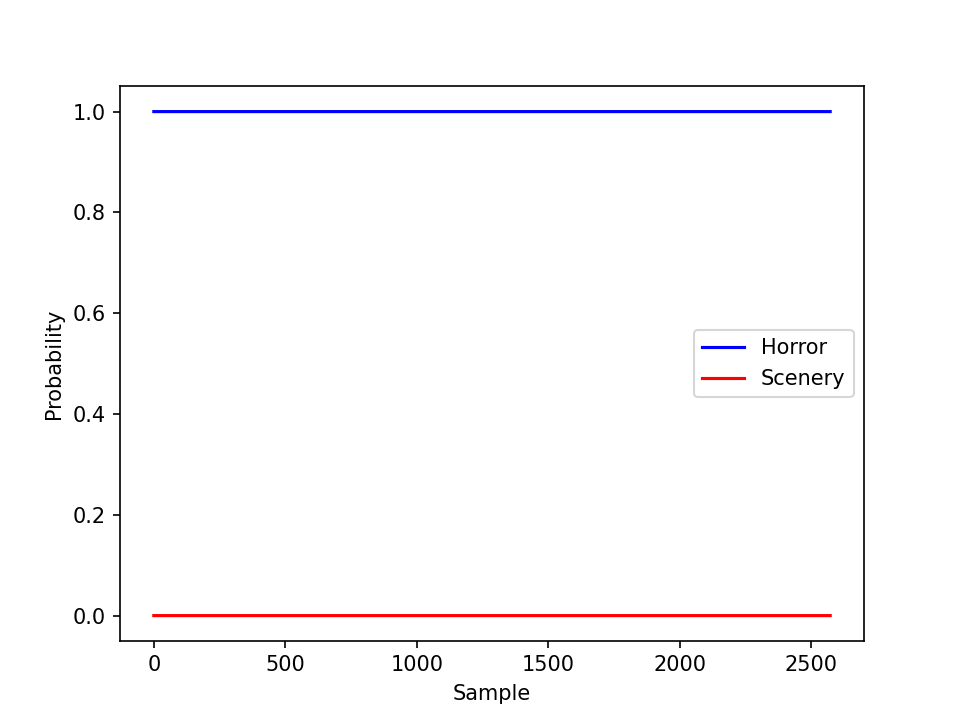

In [212]:
# Plot the evolution of predicted probabilities
plt.figure()
plt.plot(model.predict_proba(X)[:,0], label='Horror', marker='',c='b')
plt.plot(model.predict_proba(X)[:, 1], label='Scenery', marker='',c='r')
plt.xlabel('Sample')
plt.ylabel('Probability')
plt.legend()

In [217]:
columns = list(final_features.columns)
del columns[198]
columns = np.array(columns)

In [218]:
columns[rfe.get_support()==True]

array(['EEG_8_alpha', 'EEG_8_betha', 'EEG_8_gamma', 'EEG_8_theta',
       'EEG_9_alpha', 'EEG_9_betha', 'EEG_9_gamma', 'EEG_9_theta',
       'EEG_10_alpha', 'EEG_10_betha', 'EEG_10_gamma', 'EEG_10_theta',
       'EEG_11_alpha', 'EEG_11_betha', 'EEG_11_gamma', 'EEG_11_theta',
       'EEG_12_alpha', 'EEG_12_betha', 'EEG_12_gamma', 'EEG_12_theta',
       'EEG_13_alpha', 'EEG_13_betha', 'EEG_13_gamma', 'EEG_13_theta',
       'EEG_14_alpha', 'EEG_14_betha', 'EEG_14_gamma', 'EEG_14_theta',
       'EEG_15_alpha', 'EEG_15_betha', 'EEG_15_gamma', 'EEG_15_theta',
       'EEG_16_alpha', 'EEG_16_betha', 'EEG_16_gamma', 'EEG_16_theta',
       'EEG_17_alpha', 'EEG_17_betha', 'EEG_17_gamma', 'EEG_17_theta',
       'EEG_18_alpha', 'EEG_18_betha', 'EEG_18_gamma', 'EEG_19_alpha',
       'EEG_19_betha', 'EEG_19_gamma', 'EEG_19_theta', 'EEG_20_alpha',
       'EEG_20_betha', 'EEG_21_gamma', 'EEG_22_betha', 'EEG_22_gamma',
       'EEG_25_betha', 'EEG_25_gamma', 'EEG_26_gamma', 'EEG_26_theta',
       'EEG_27

## Cross-Validation Real-time Features

In [13]:
final_features[final_features.columns[:-1]]

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-0.220528,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-0.220840,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-0.221111,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-0.221124,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-0.220867,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,0.003700,0.002253,0.002032,0.018953,0.001776,0.001339,0.001231,0.007712,0.000989,0.001082,...,-0.058370,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-0.058370,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-0.057987,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-0.062740,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787


In [17]:
from sklearn.model_selection import StratifiedKFold,StratifiedShuffleSplit
from sklearn import metrics

In [43]:
window_size = 120
overlap = 0.1
step_size = int(window_size * (1 - overlap))

In [44]:
final_features

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556,Horror
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162,Horror
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476,Horror
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800,Horror
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569,0.003700,0.002253,0.002032,0.018953,0.001776,0.001339,0.001231,0.007712,0.000989,0.001082,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2570,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2571,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332,Scenery
2572,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery


In [45]:
non_overlap_final = [final_features.iloc[i:i + window_size] for i in range(0, len(final_features), step_size)]
non_overlapping_df = pd.concat(non_overlap_final, ignore_index=True)

In [46]:
non_overlapping_df

,EEG_1_alpha,EEG_1_betha,EEG_1_gamma,EEG_1_theta,EEG_2_alpha,EEG_2_betha,EEG_2_gamma,EEG_2_theta,EEG_3_alpha,EEG_3_betha,...,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_nn20,RRV_nn50,RRV_pNN50,RRV_pNN20,RRV_HF,RRV_SD1,Category
0,0.001162,0.000749,0.000772,0.004208,0.001538,0.001183,0.001121,0.005206,0.000468,0.000616,...,-50.0,-12.6021,-0.026023,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.658556,Horror
1,0.001148,0.000754,0.000771,0.004167,0.001516,0.001188,0.001121,0.005170,0.000466,0.000617,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.719162,Horror
2,0.001139,0.000752,0.000771,0.004121,0.001510,0.001187,0.001124,0.005144,0.000461,0.000614,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.748476,Horror
3,0.001126,0.000747,0.000767,0.004044,0.001510,0.001190,0.001123,0.005107,0.000458,0.000611,...,-50.0,-15.5673,-0.034981,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.773800,Horror
4,0.001115,0.000745,0.000765,0.003989,0.001507,0.001192,0.001126,0.005097,0.000454,0.000604,...,-50.0,-14.0847,-0.030502,-22.0,-12.0,-30.000000,-46.388889,NaN,-67.737642,Horror
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,0.003700,0.002253,0.002032,0.018953,0.001776,0.001339,0.001231,0.007712,0.000989,0.001082,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2846,0.003817,0.002319,0.002097,0.019528,0.001765,0.001319,0.001221,0.007678,0.000990,0.001088,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-27.315515,Scenery
2847,0.004106,0.002474,0.002219,0.021962,0.001889,0.001483,0.001290,0.008936,0.000915,0.001080,...,-65.0,22.9803,0.089131,-16.0,-7.0,25.555556,20.277778,NaN,-27.216332,Scenery
2848,0.004205,0.002540,0.002263,0.022460,0.001883,0.001473,0.001276,0.008869,0.000911,0.001076,...,-65.0,22.9803,0.089131,-16.0,-8.0,14.444444,20.277778,NaN,-28.312787,Scenery


In [47]:
imp = SimpleImputer(missing_values=np.nan,strategy = "mean")
scaler = StandardScaler()
model = ensemble.RandomForestClassifier(bootstrap=True,random_state=0)
validator = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
    
X=np.array(final_features[final_features.columns[:-1]])
Y = np.array(final_features["Category"])

imp = imp.fit(X)
X = imp.transform(X)

accuracy,precision,f1_score,roc_auc,recall,y_true,y_predict=[],[],[],[],[],[],[]

for train_index,test_index in validator.split(X,Y.ravel()):

        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]

        scaler = scaler.fit(X_train,Y_train.ravel())
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)

        rfe = feature_selection.RFE(model,step=1)
        rfe = rfe.fit(X_train,Y_train.ravel())
        X_train = rfe.transform(X_train)
        X_test = rfe.transform(X_test)

        model.fit(X_train,Y_train.ravel())

        accuracy.append(metrics.accuracy_score(Y_test,model.predict(X_test)))
        precision.append(metrics.precision_score(Y_test,model.predict(X_test),average="weighted",zero_division=1))
        f1_score.append(metrics.f1_score(Y_test,model.predict(X_test),average="weighted"))
#         recall.append(metrics.recall_score(Y_test,model.predict(X_test),average="weighted"))
#         roc_auc.append(metrics.roc_auc_score(Y_test,model.predict_proba(X_test),average="weighted",multi_class="ovr"))

        y_true.append(Y_test)
        y_predict.append(model.predict(X_test))

results = (np.mean(accuracy),np.mean(precision),np.mean(f1_score))#,np.mean(recall),np.mean(roc_auc))
print(results)

(0.9988326848249027, 0.9988415260009891, 0.9988325543063858)


In [22]:
X.shape

(2574, 197)

<IPython.core.display.Javascript object>


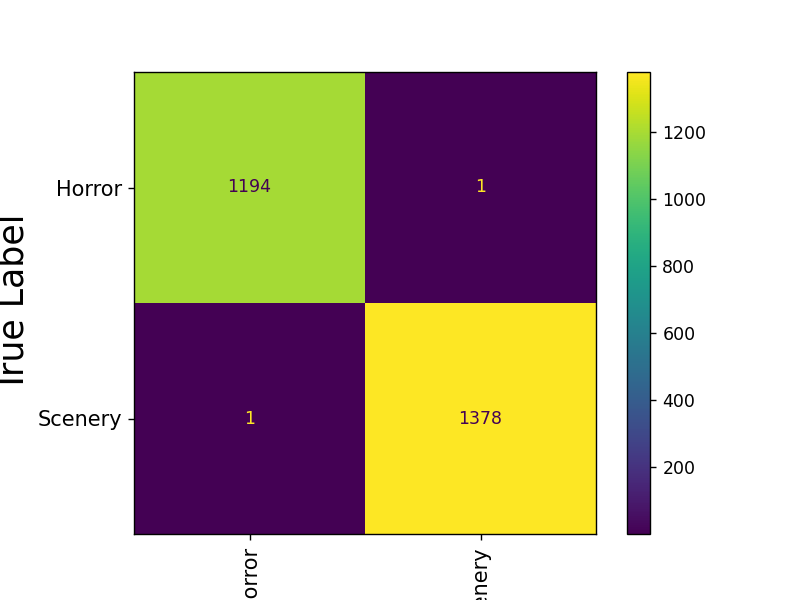

In [23]:
cm = metrics.confusion_matrix(np.concatenate(y_true),np.concatenate(y_predict),labels=model.classes_)
disp = metrics.ConfusionMatrixDisplay(cm,display_labels=model.classes_)
disp.plot()

plt.xlabel("Predicted Label",fontsize=20)
plt.ylabel("True Label",fontsize=20)
plt.xticks(rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.show()